## Configuration

In [17]:
import pandas as pd
import numpy as np

In [18]:
from src.widgets import get_config_widgets, select_features
from src.dataset import get_datasets, standardize_data
from src.feature import create_features, create_standardized_features, split
from src.prediction import linear_regression, predict_return_mae, predict_return_mse
from src.plot import plot_merged_datasets, feature_importance, plot_predicted

In [19]:
price_interval, prediction_date_picker, eval_size, standardize =  get_config_widgets()

IntRangeSlider(value=(-74, 222), continuous_update=False, description='Energy Price Interval', max=900, min=-4…

DatePicker(value=None, description='Prediction Date', step=1)

FloatSlider(value=0.05, description='Evaluation Set Size', max=0.2, step=0.01)

Checkbox(value=False, description='Standardize')

## Data loading

In [20]:
merged_df, e_price_df = get_datasets()

standardized_merged_df, standardized_e_price_df, e_price_scaler = standardize_data(merged_df.copy(), e_price_df.copy())



## Feature Selection

In [21]:
get_features, default_features = select_features()

Output()

Button(description='Confirm Selection', style=ButtonStyle())

In [22]:
selected_features = get_features()
FEATURES = default_features if not selected_features else selected_features

TARGET = merged_df["Price"]
TARGET_STANDARDIZED = standardized_merged_df["Price"]

features_df = create_features(merged_df)
features_standardized_df = create_standardized_features(standardized_merged_df, e_price_scaler)

combined_df = pd.concat([features_df[FEATURES], TARGET], axis=1)
combined_standardized_df = pd.concat([features_standardized_df[FEATURES], TARGET_STANDARDIZED], axis=1)


train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST = split(combined_df,eval_size.value)
train_standardized, eval_standardized, test_standardized, _, _ = split(combined_standardized_df,eval_size.value)

In [23]:
# plot_merged_datasets(train, eval, test, SPLIT_DATE_EVAL, SPLIT_DATE_TEST)

In [24]:
# RERUN WHEN TICKING the STANDARDIZED BOX 

TARGET = "Price"

scalar = e_price_scaler if standardize.value else None

train, eval, test = (train_standardized, eval_standardized, test_standardized) if standardize.value else (train, eval, test)

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

X_val = eval[FEATURES]
y_val = eval[TARGET]

limit_XGB = scalar.fit_transform(np.array(price_interval.value).reshape(-1, 1))[:, 0] if standardize.value else (price_interval.value)
min_price, max_price = limit_XGB[0], limit_XGB[1]

train_XGB = train.copy()[
    (train[TARGET] >= min_price) &
    (train[TARGET] <= max_price)
]

test_XGB = test.copy()[
    (test[TARGET] >= min_price) &
    (test[TARGET] <= max_price)
]

eval_XGB = eval.copy()[
    (eval[TARGET] >= min_price) &
    (eval[TARGET] <= max_price)
]

X_train_XGB = train_XGB[FEATURES]
y_train_XGB = train_XGB[TARGET]

X_test_XGB = test_XGB[FEATURES]
y_test_XGB = test_XGB[TARGET]

X_val_XGB = eval_XGB[FEATURES]
y_val_XGB = eval_XGB[TARGET]

## Prediction

### Linear Regression

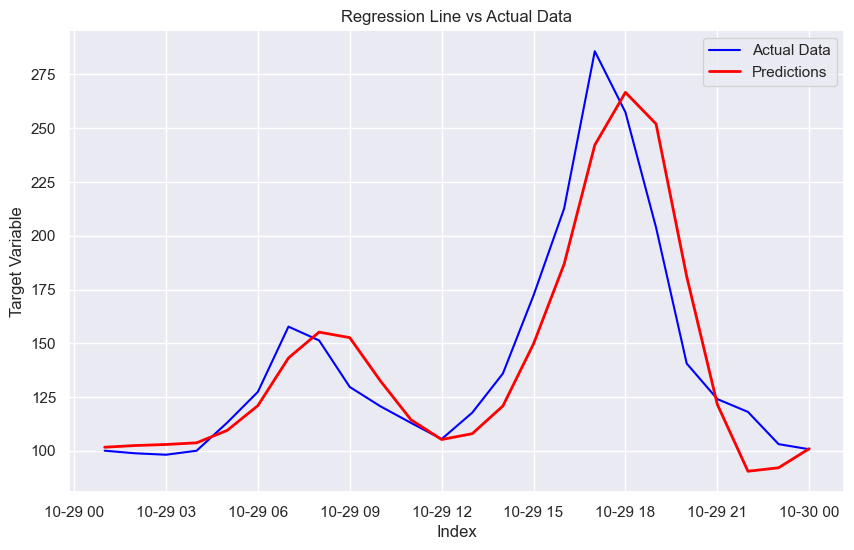

Root Mean Squared Error: 19.72131795309189
Mean Absolute Error: 13.941927953296739
R-squared: 0.8442773063427089


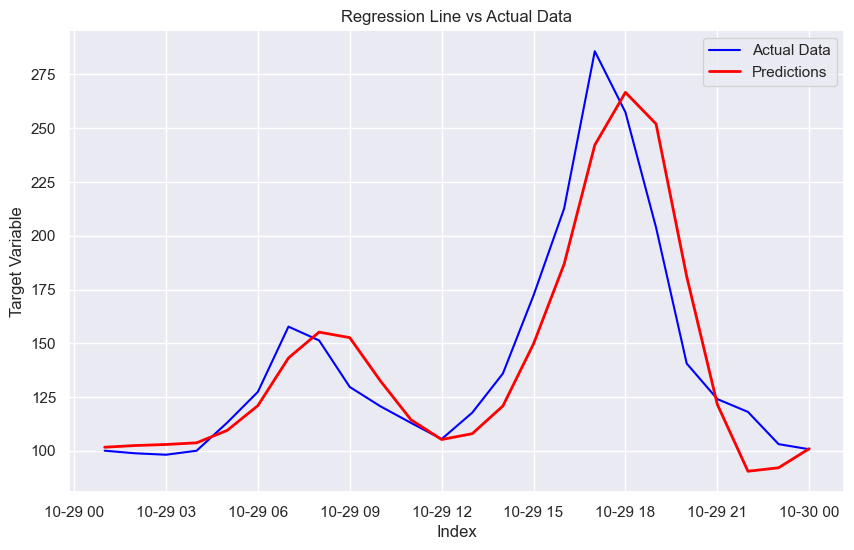

Root Mean Squared Error: 19.72131795309189
Mean Absolute Error: 13.941927953296739
R-squared: 0.8442773063427089


In [ ]:
linear_regression(X_train, y_train, X_test, y_test, scalar)
linear_regression(X_train_XGB, y_train_XGB, X_test_XGB, y_test_XGB, scalar)

### Prophet

### XGBoost

In [26]:
best_params = {
    "base_score": 0.380924762889507,
    "early_stopping_rounds": 215,
    "max_depth": 80,
    "learning_rate": 0.06,
    "n_estimators": 150,
    "gamma": 0.9,
    "min_child_weight": 6,
    "subsample": 0.5719023844219375,
    "colsample_bytree": 0.8815691043681952,
}
y_predicted_mse, model_mse = predict_return_mse(best_params, X_train, y_train, X_val, y_val, X_test)
y_predicted_mae, model_mae = predict_return_mae(best_params, X_train, y_train, X_val, y_val, X_test)

[0]	validation_0-rmse:87.01272
[25]	validation_0-rmse:22.91961
[50]	validation_0-rmse:12.68357
[75]	validation_0-rmse:11.38793
[100]	validation_0-rmse:11.09659
[125]	validation_0-rmse:10.98154
[149]	validation_0-rmse:10.91657
[0]	validation_0-mae:75.32006
[25]	validation_0-mae:17.10485
[50]	validation_0-mae:7.18715
[75]	validation_0-mae:6.09672
[100]	validation_0-mae:5.95519
[125]	validation_0-mae:5.94091
[149]	validation_0-mae:5.93593


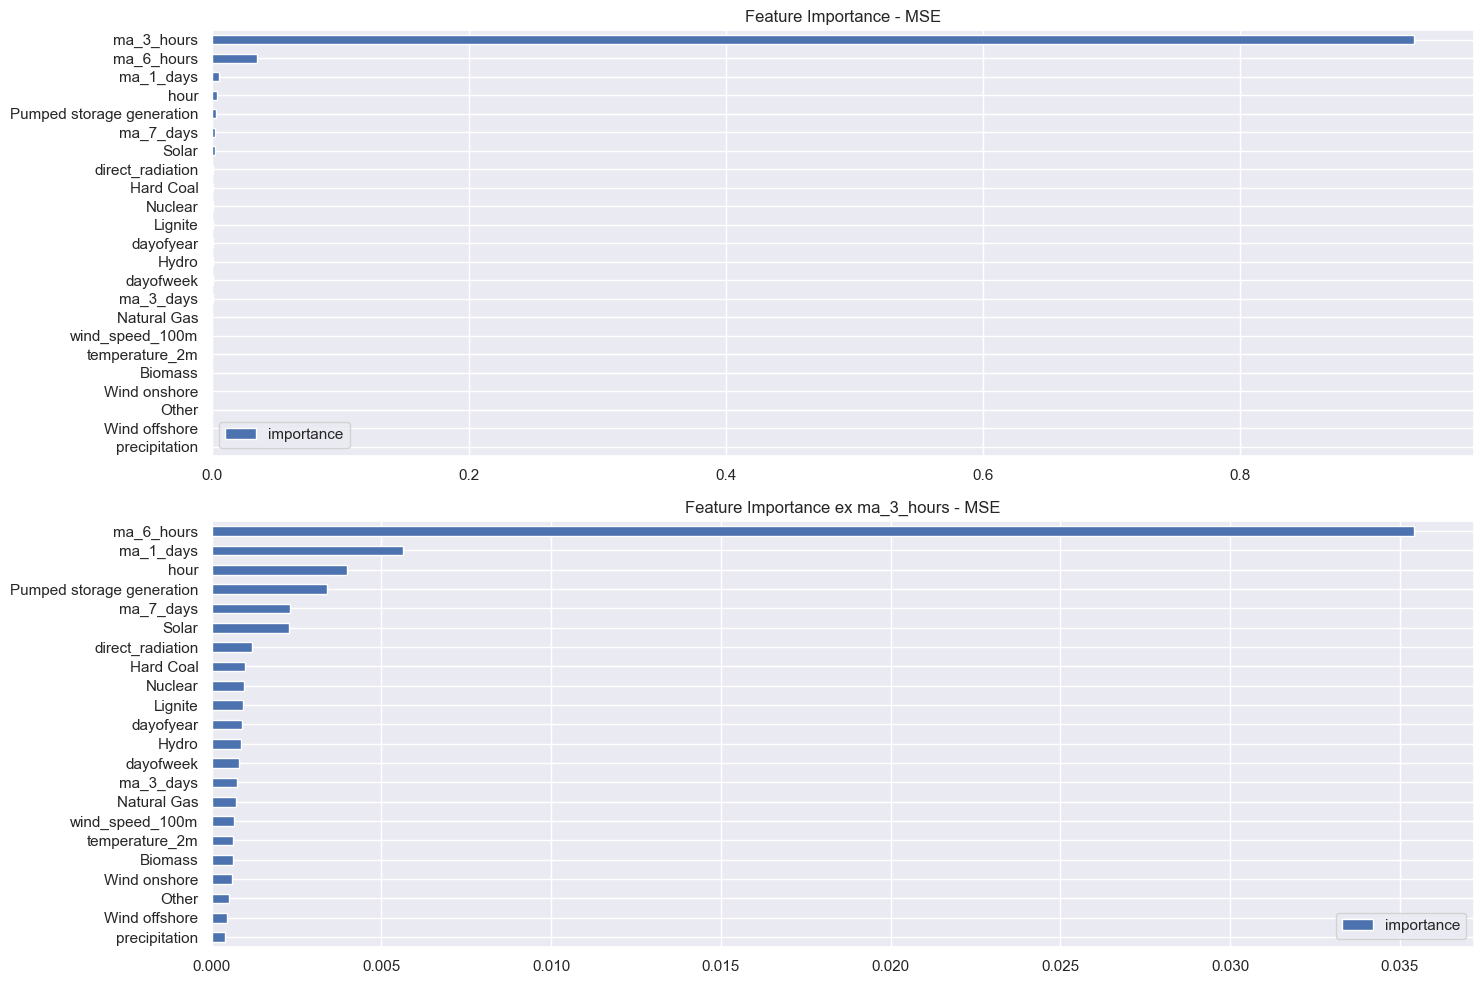

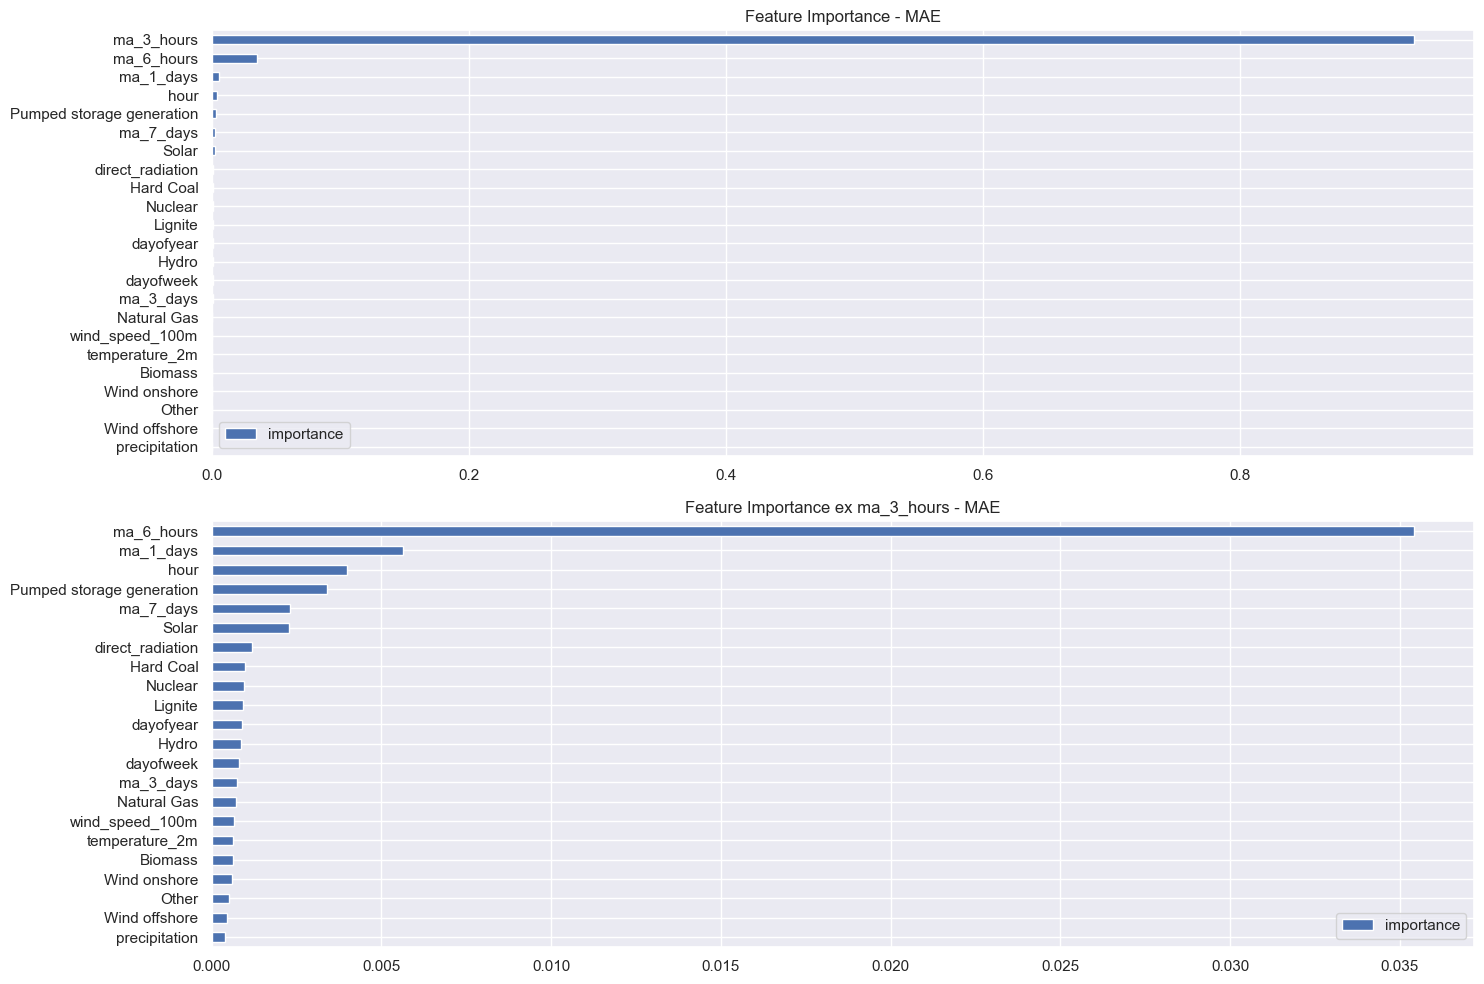

In [27]:
feature_importance(model_mse, "MSE")
feature_importance(model_mae, "MAE")

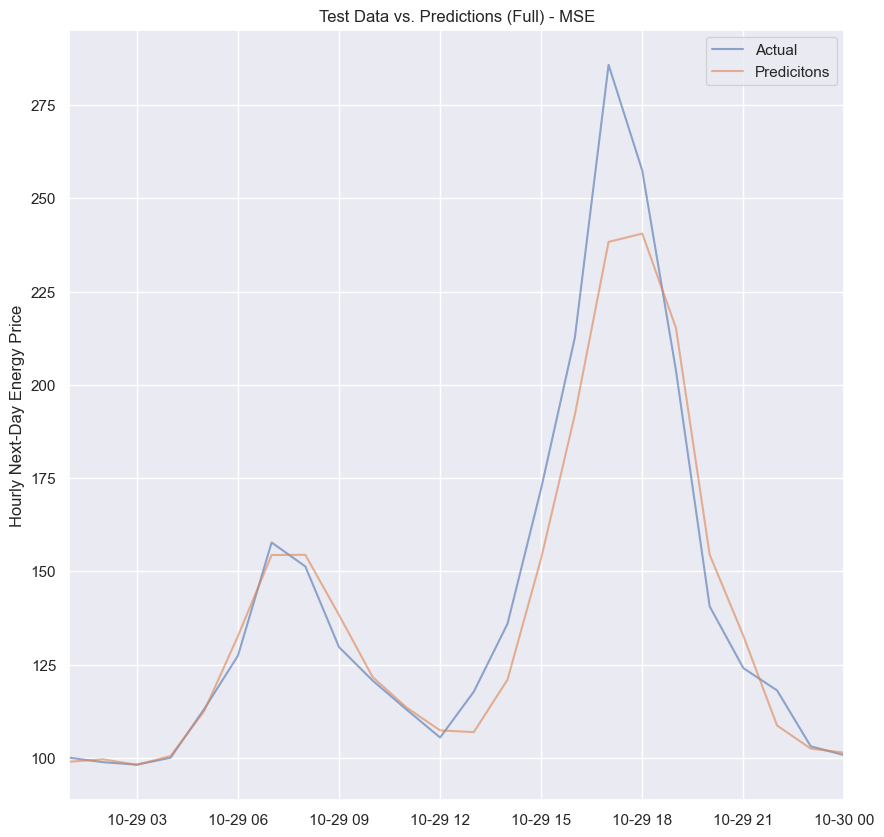

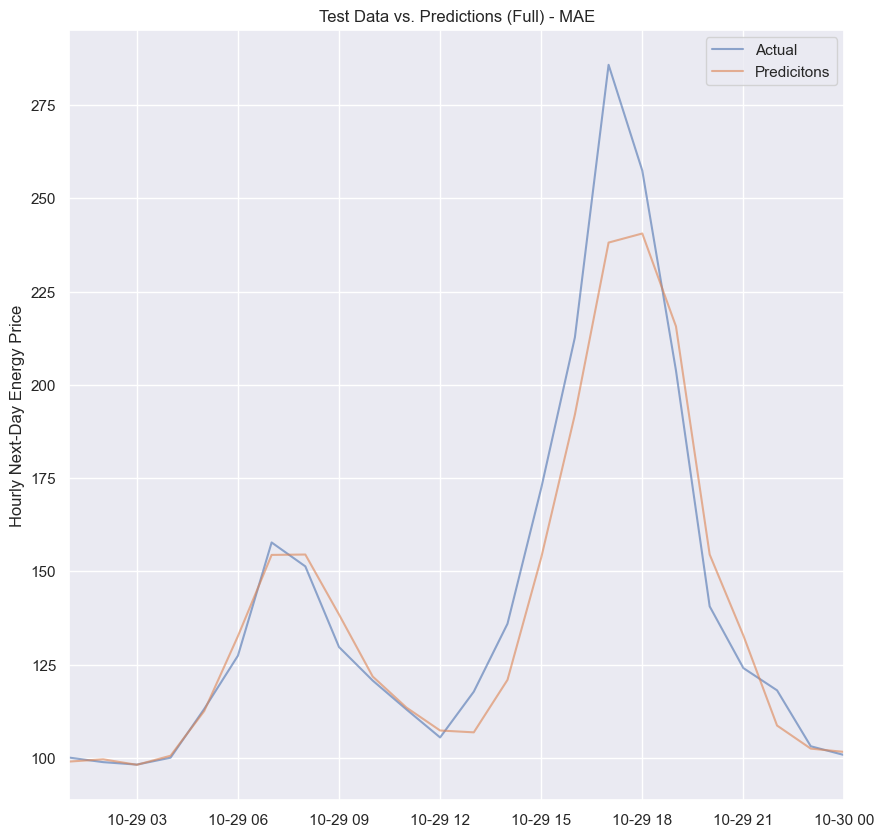

In [28]:
for predictions, objective_name in [(y_predicted_mse, "MSE"), (y_predicted_mae, "MAE")]:
    plot_predicted(test, predictions, objective_name)

# buf = io.BytesIO()
# plt.savefig(buf, format='png')
# plt.show()
# plt.close()
# buf.seek(0)

# ts_image = Image.open(buf)

## Results